In [21]:
import json
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
ENTITY_MAPPER = {
    # Location
    "city_name":         "Location",
    "airport_name":      "Location",
    "airport_code":      "Location",
    "state_name":        "Location",
    "state_code":        "Location",
    "country_name":      "Location",

    # Airline
    "airline_name":      "Airline",
    "airline_code":      "Airline",

    # DateTime
    "day_name":          "DateTime",
    "day_number":        "DateTime",
    "month_name":        "DateTime",
    "year":              "DateTime",
    "date_relative":     "DateTime",
    "today_relative":    "DateTime",
    "days_code":         "DateTime",
    "time":              "DateTime",
    "start_time":        "DateTime",
    "end_time":          "DateTime",
    "flight_time":       "DateTime",

    # Modifier
    "period_of_day":     "Modifier",
    "period_mod":        "Modifier",
    "time_relative":     "Modifier",
    "flight_mod":        "Modifier",
    "mod":               "Modifier",

    # Price
    "round_trip":        "Price",
    "cost_relative":     "Price",
    "fare_amount":       "Price",
    "fare_basis_code":   "Price",

    # FlightDetails
    "class_type":        "FlightDetails",
    "transport_type":    "FlightDetails",
    "flight_stop":       "FlightDetails",
    "flight_days":       "FlightDetails",
    "connect":           "FlightDetails",
    "restriction_code":  "FlightDetails",
    "economy":           "FlightDetails",

    # Identifier
    "flight_number":     "Identifier",
    "aircraft_code":     "Identifier",

    # Meal
    "meal":              "Meal",
    "meal_description":  "Meal",
    "meal_code":         "Meal",

    # Other
    "or":                "X",
    "O":                 "X",
}

INTENT_MAPPER = {
    # Booking-related queries (flights, fares, ground service)
    "flight":                      "Flight",
    "airfare":                     "Fare",
    "ground_service":              "Fare",
    "flight+airfare":              "Fare",
    "ground_service+ground_fare":  "Fare",
    "ground_fare":                 "Fare",
    "cheapest":                    "Fare",

    # Flight information (airline, aircraft, flight numbers)
    "airline":                     "FlightInfo",
    "abbreviation":                "FlightInfo",
    "airline+flight_no":           "FlightInfo",
    "aircraft":                    "FlightInfo",
    "flight_no":                   "FlightInfo",
    "aircraft+flight+flight_no":   "FlightInfo",
    "airfare+flight":              "FlightInfo",

    # Location-based queries
    "airport":                     "Location",
    "city":                        "Location",
    "distance":                    "Location",

    # Scheduling/time queries
    "flight_time":                 "Schedule",
    "airfare+flight_time":         "Schedule",
    "day_name":                    "Schedule",

    # Capacity/quantity queries
    "capacity":                    "Capacity",
    "quantity":                    "Capacity",

    # Meal-related queries
    "meal":                        "Meal",

    # Restriction or rule queries
    "restriction":                 "Restriction",
}

slot2id = {s: i for i, s in enumerate(set(ENTITY_MAPPER.values()))}
intent2id = {s: i for i, s in enumerate(set(INTENT_MAPPER.values()))}

pad_tag = "[PAD]"
slot2id[pad_tag] = len(slot2id)

In [64]:
print(slot2id.keys())
print(intent2id.keys())

dict_keys(['Airline', 'Meal', 'X', 'Location', 'Modifier', 'DateTime', 'FlightDetails', 'Identifier', 'Price', '<PAD>'])
dict_keys(['Fare', 'Meal', 'Capacity', 'FlightInfo', 'Location', 'Flight', 'Restriction', 'Schedule'])


In [24]:
def process_entity(st):
    entities = []
    
    for p in st.split(" "):
        p = p.split(".")[-1].split("-")[-1]
        entities.append(ENTITY_MAPPER.get(p, p))
        
    return entities

def process_data(df):

    df.loc[:, 'intent'] = df.intent.transform(lambda x: INTENT_MAPPER.get(x, x))
    df.loc[:, 'entity'] = df.slots.transform(process_entity)

    records = df[['text', 'entity', 'intent']].to_json(orient='records')
    records = json.loads(records)
    return records
    


In [25]:
train = pd.read_csv("https://huggingface.co/datasets/tuetschek/atis/raw/main/atis_train.csv")
test  = pd.read_csv("https://huggingface.co/datasets/tuetschek/atis/raw/main/atis_test.csv")


train_records = process_data(train)
test_records  = process_data(test)

with open("../data/train.json", 'w') as f:
    json.dump(train_records, f, indent=4)

with open("../data/test.json", 'w') as f:
    json.dump(test_records, f, indent=4)



In [26]:
tokenizer     = AutoTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
tokenizer

In [59]:

text = "i need a flight tomorrow from columbus to minneapolis."

encoding = tokenizer(
    text,
    padding="max_length",
    truncation=True,
    max_length=20,
    return_attention_mask=True,
    return_tensors="pt",
    add_special_tokens=False
)

encoding

{'input_ids': tensor([[ 1045,  2342,  1037,  3462,  4826,  2013,  8912,  2000, 11334,  1012,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

In [60]:
tokens    = tokenizer.convert_ids_to_tokens(encoding.input_ids[0])
word_ids  = encoding.word_ids(batch_index=0)  

In [61]:
tokens, word_ids

(['i',
  'need',
  'a',
  'flight',
  'tomorrow',
  'from',
  'columbus',
  'to',
  'minneapolis',
  '.',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]'],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None])

In [5]:
records = process_data(train)
records[5:7]

[{'text': 'i need a flight tomorrow from columbus to minneapolis',
  'entity': ['X', 'X', 'X', 'X', 'DateTime', 'X', 'Location', 'X', 'Location'],
  'intent': 'Flight'},
 {'text': 'what kind of aircraft is used on a flight from cleveland to dallas',
  'entity': ['X',
   'X',
   'X',
   'X',
   'X',
   'X',
   'X',
   'X',
   'X',
   'X',
   'Location',
   'X',
   'Location'],
  'intent': 'FlightInfo'}]

In [ ]:
len([r for r in records if len(r['text']) <= 7])

3279

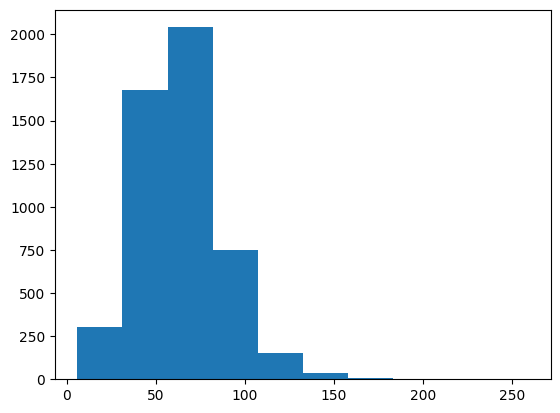

In [32]:

plt.hist(list(map(lambda x: len(x['text']), records)));

In [ ]:

class ATISDataset(Dataset):
    """
    Loads ATIS-style JSON, tokenizes text, and aligns slot tags & intent labels.
    """
    def __init__(self, data,
                tokenizer: AutoTokenizer, slot2id: dict,
                intent2id: dict, max_len: int = 100):
        self.max_len = max_len
        self.texts = []
        self.slot_tags = []
        self.intent_ids = []
        for d in data:
            if len(d['text']) >= max_len:
                continue 
            self.texts.append(d['text'])
            self.slot_tags.append(d['entity'])
            self.intent_ids.append(intent2id[d['intent']])
            
        self.tokenizer = tokenizer
        self.slot2id = slot2id
        self.intent2id = intent2id
        self.id2intent = {intent: lbl for intent, lbl in intent2id.items()}

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        tags = self.slot_tags[idx]
        intent = self.intent_ids[idx]
        enc = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_attention_mask=True,
            return_tensors="pt"
        )
        input_ids = enc.input_ids.squeeze(0)
        attention_mask = enc.attention_mask.squeeze(0)
        
        # Align tags (naive one-tag-per-word); pad/truncate
        tag_ids = [self.slot2id.get(t, self.slot2id["[PAD]"]) for t in tags]
        if len(tag_ids) < self.max_len:
            tag_ids += [self.slot2id["[PAD]"]] * (self.max_len - len(tag_ids))
        else:
            tag_ids = tag_ids[: self.max_len]
            
        slot_labels = torch.tensor(tag_ids, dtype=torch.long)
        intent_label = torch.tensor(intent, dtype=torch.long)
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "intent_label": intent_label,
            "slot_labels": slot_labels
        }

In [40]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
ds = ATISDataset(records, tokenizer, slot2id, intent2id)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [41]:
ds[1]

{'input_ids': tensor([ 101, 2054, 7599, 2024, 2800, 2013, 6278, 2000, 6222, 2006, 9432, 2851,
          102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [89]:
train_records

[{'text': 'i want to fly from boston at 838 am and arrive in denver at 1110 in the morning',
  'entity': ['X',
   'X',
   'X',
   'X',
   'X',
   'city_name',
   'X',
   'time',
   'time',
   'X',
   'X',
   'X',
   'city_name',
   'X',
   'time',
   'X',
   'X',
   'X'],
  'intent': 'flight'},
 {'text': 'what flights are available from pittsburgh to baltimore on thursday morning',
  'entity': ['X',
   'X',
   'X',
   'X',
   'X',
   'city_name',
   'X',
   'city_name',
   'X',
   'day_name',
   'X'],
  'intent': 'flight'},
 {'text': 'cheapest airfare from tacoma to orlando',
  'entity': ['X', 'X', 'X', 'city_name', 'X', 'city_name'],
  'intent': 'airfare'},
 {'text': 'round trip fares from pittsburgh to philadelphia under 1000 dollars',
  'entity': ['X', 'X', 'X', 'X', 'city_name', 'X', 'city_name', 'X', 'X', 'X'],
  'intent': 'airfare'},
 {'text': 'i need a flight tomorrow from columbus to minneapolis',
  'entity': ['X', 'X', 'X', 'X', 'X', 'X', 'city_name', 'X', 'city_name'],
  'int